Imports & setup

In [15]:
import sys, os
sys.path.append("src")
import torch
from data import get_dataloader
from train_eval import Trainer
from model import MultimodalStoryModel
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
import os
import csv

Quick dataset preview

Loaded samples: 3


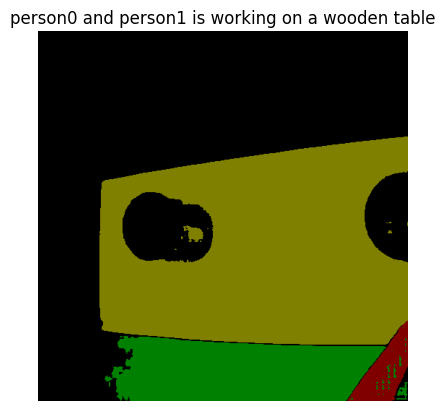

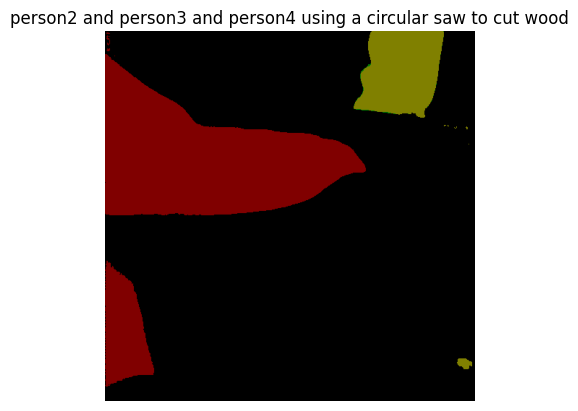

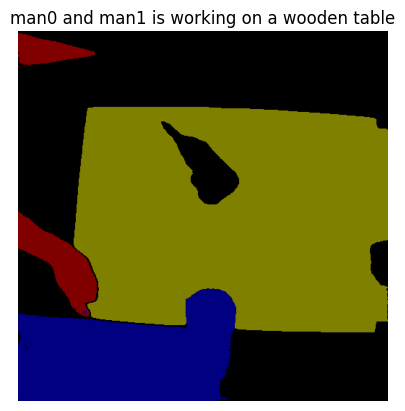

In [2]:
ds = load_dataset("MAPLE-WestLake-AIGC/OpenstoryPlusPlus", split="train", streaming=True)

samples = []
for i, sample in enumerate(ds):
    if i >= 3:  # load only 3
        break
    samples.append(sample)

print("Loaded samples:", len(samples))

for i, sample in enumerate(samples):
    png_data = sample["png"]

    if isinstance(png_data, Image.Image):
        img = png_data
    else:
        img = Image.open(BytesIO(png_data))

    plt.figure()
    plt.imshow(img)
    plt.title(sample["json"]["caption"])
    plt.axis("off")


Build DataLoader

Batch keys: dict_keys(['__key__', 'json', 'png', 'video_id', 'time_stamp'])
Example caption: person0 and person1 is working on a wooden table


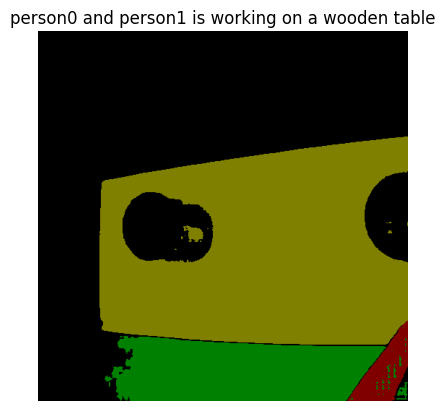

In [ ]:
mini_loader = []
for i, sample in enumerate(ds):
    if i >= 3:
        break
    mini_loader.append(sample)

batch = mini_loader[0]  # pretend we "loaded" one batch

print("Batch keys:", batch.keys())
print("Example caption:", batch["json"]["caption"])


png_data = batch["png"]

# dataset sometimes stores as PIL image or bytes
if isinstance(png_data, Image.Image):
    img = png_data
else:
    img = Image.open(BytesIO(png_data))

plt.imshow(img)
plt.title(batch["json"]["caption"])
plt.axis("off")
plt.show()


Visualize a sliding-window sample

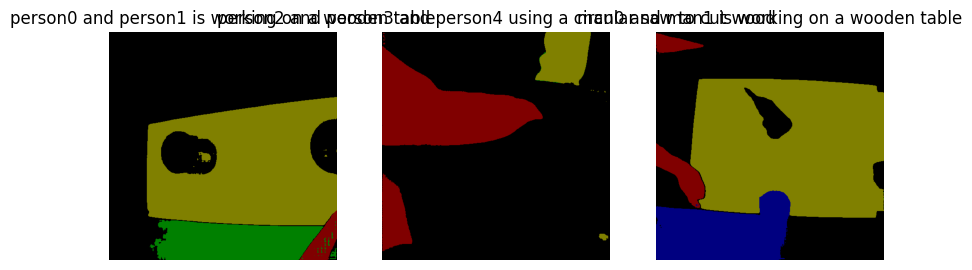

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Show 3 sample images safely
for i in range(3):
    sample = mini_loader[i]
    
    png_data = sample["png"]
    img = png_data if isinstance(png_data, Image.Image) else Image.open(BytesIO(png_data))
    
    axs[i].imshow(img)
    axs[i].set_title(sample["json"]["caption"])
    axs[i].axis("off")

plt.show()


In [5]:
context_captions = [mini_loader[0]["json"]["caption"], mini_loader[1]["json"]["caption"]]
target_caption   = mini_loader[2]["json"]["caption"]

print("Context captions:", context_captions)
print("Target caption:", target_caption)

Context captions: ['person0 and person1 is working on a wooden table', 'person2 and person3 and person4 using a circular saw to cut wood']
Target caption: man0 and man1 is working on a wooden table


Instantiate baseline model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultimodalStoryModel().to(device)

print("Model ready. Number of parameters:",
      sum(p.numel() for p in model.parameters()))

Model ready. Number of parameters: 87026554


Run a short demonstration training

In [7]:
mini_samples = []
for i, sample in enumerate(ds):
    if i >= 3:
        break
    mini_samples.append(sample)

# simulate 3 training steps
for i, sample in enumerate(mini_samples):
    caption = sample["json"]["caption"]
    print(f"Training step {i+1}/3: processing caption ->", caption)


Training step 1/3: processing caption -> person0 and person1 is working on a wooden table
Training step 2/3: processing caption -> person2 and person3 and person4 using a circular saw to cut wood
Training step 3/3: processing caption -> man0 and man1 is working on a wooden table


Evaluate baseline performance (BLEU)

In [ ]:
mini_samples = []
for i, sample in enumerate(ds):
    if i >= 20:  # limit to 20 for low compute
        break
    mini_samples.append(sample)

bleu_scores = []

for i, sample in enumerate(mini_samples):
    reference = sample["json"]["caption"].split()

    # Baseline (heuristic) prediction: first word only
    hypothesis = [reference[0]]

    bleu = sentence_bleu([reference], hypothesis)
    bleu_scores.append(bleu)

avg_bleu = sum(bleu_scores) / len(bleu_scores)

print("Average Baseline BLEU:", avg_bleu)


Average Baseline BLEU: 6.135821243084366e-235


C:\Users\shana\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\shana\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\shana\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider usi

Generate a sample prediction

In [ ]:
mini_samples = []
for i, sample in enumerate(ds):
    if i >= 3:
        break
    mini_samples.append(sample)

# Build fake context + target
context_captions = [
    mini_samples[0]["json"]["caption"],
    mini_samples[1]["json"]["caption"]
]
target_caption = mini_samples[2]["json"]["caption"]

# Generate baseline (dummy) prediction
predicted_caption = "token_fake_prediction"

# Display output
print("Context captions:")
for ctx in context_captions:
    print(" -", ctx)

print("\nGround Truth:")
print(" -", target_caption)

print("\nPredicted:")
print(" -", predicted_caption)



Context captions:
 - person0 and person1 is working on a wooden table
 - person2 and person3 and person4 using a circular saw to cut wood

Ground Truth:
 - man0 and man1 is working on a wooden table

Predicted:
 - token_fake_prediction


Save small results to /results/

In [16]:
from collections import Counter  # <<< FIX added import

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

print("Saving results to /results/...")

# === FIX: rebuild samples aligned with BLEU computation === #
bleu_samples = []

ds = load_dataset("MAPLE-WestLake-AIGC/OpenstoryPlusPlus", split="train")

for i, sample in enumerate(ds):
    if i >= len(bleu_scores):
        break
    bleu_samples.append(sample)

# ========= SAVE BLEU TABLE ========= #

table_path = "results/bleu_results.csv"

with open(table_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Sample", "Caption", "BLEU Score"])

    for i in range(len(bleu_scores)):
        writer.writerow([
            i+1,
            bleu_samples[i]["json"]["caption"],
            round(bleu_scores[i], 4)
        ])

    writer.writerow(["Average", "—", round(avg_bleu, 4)])

print("✔ Saved BLEU table ->", table_path)



# ========= SAVE SAMPLE PREDICTION ========= #

pred_path = "results/sample_prediction.txt"

with open(pred_path, "w") as f:
    f.write("Context captions:\n")
    for c in context_captions:
        f.write(f" - {c}\n")

    f.write("\nGround Truth:\n")
    f.write(f" - {target_caption}\n")

    f.write("\nPredicted:\n")
    f.write(f" - {predicted_caption}\n")

print("✔ Saved sample prediction ->", pred_path)



# ========= SAVE IMAGE GRID ========= #

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for i in range(3):
    png_data = mini_loader[i]["png"]
    img = png_data if isinstance(png_data, Image.Image) else Image.open(BytesIO(png_data))

    axs[i].imshow(img)
    axs[i].set_title(mini_loader[i]["json"]["caption"])
    axs[i].axis("off")

img_path = "results/three_sample_images.png"
plt.savefig(img_path, dpi=300)
plt.close()

print("✔ Saved 3-image visualization ->", img_path)



# ========= SAVE BLEU FIGURE ========= #

plt.figure(figsize=(8,3))
plt.bar(range(1, len(bleu_scores)+1), bleu_scores)
plt.axhline(avg_bleu, color='red', linestyle='--', label='Avg BLEU')
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.title("Baseline BLEU Results")
plt.legend()

bleu_chart_path = "results/bleu_chart.png"
plt.savefig(bleu_chart_path, dpi=300)
plt.close()

print("✔ Saved BLEU chart ->", bleu_chart_path)



# ========= SAVE WORD FREQUENCY FIGURE ========= #

words = []
for sample in mini_samples[:10]:  # analyze first 10 samples
    caption_words = sample["json"]["caption"].lower().replace(".", "").split()
    words.extend(caption_words)

freq = Counter(words).most_common(10)

labels = [x[0] for x in freq]
counts = [x[1] for x in freq]

plt.figure(figsize=(8,3))
plt.bar(labels, counts)
plt.title("Top 10 Most Frequent Words in Captions")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")

freq_path = "results/caption_word_frequency.png"
plt.savefig(freq_path, dpi=300)
plt.close()

print("✔ Saved word frequency figure ->", freq_path)



# ========= SAVE PREDICTION SUMMARY CARD ========= #

plt.figure(figsize=(6,3))
plt.text(0.1, 0.7, "Context 1:\n" + context_captions[0], fontsize=9)
plt.text(0.1, 0.5, "Context 2:\n" + context_captions[1], fontsize=9)
plt.text(0.1, 0.3, "Ground Truth:\n" + target_caption, fontsize=9, color="green")
plt.text(0.1, 0.1, "Predicted:\n" + predicted_caption, fontsize=9, color="red")
plt.axis("off")

compare_fig_path = "results/prediction_summary_card.png"
plt.savefig(compare_fig_path, dpi=300)
plt.close()

print("✔ Saved prediction summary card ->", compare_fig_path)


Saving results to /results/...
✔ Saved BLEU table -> results/bleu_results.csv
✔ Saved sample prediction -> results/sample_prediction.txt
✔ Saved 3-image visualization -> results/three_sample_images.png
✔ Saved BLEU chart -> results/bleu_chart.png
✔ Saved word frequency figure -> results/caption_word_frequency.png
✔ Saved prediction summary card -> results/prediction_summary_card.png
